# Compare success of different lineages
Natalia Vélez, July 2020

Now that we've built a graph representation of family trees, we'll use it to compare lineages and operationalize a success measure.

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import notebook

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

sns.set_context('talk')
sns.set_style('white')

## Set up data

Load lifelog data:

In [2]:
era_df = pd.read_csv('outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
era_df.head()

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,release,era,hash,playerID,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,342.0,boundless,2cdc4d0b016f9c0d96d27013f1d19c42596e0c5c,3080130,1592288229,3080111,[-454640 41],1592288538,[-454625 49],5.14,hunger,-454640,41,-454625,49,CLAUDINE,P
1,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080128,1592288191,3080105,[-454394 -4],1592291791,[-454383 15],60.00,oldAge,-454394,-4,-454383,15,DACY,LIGHTNING
2,342.0,boundless,c5838da39fd525a2ac24aee049dae6a42e502236,3080125,1592288138,3080101,[-311131 -322],1592291738,[-311112 -325],59.98,hunger,-311131,-322,-311112,-325,SHOKO,GREATHOUSE
3,342.0,boundless,11f9fce50bbc1ebbba5126434aea123e79249942,3080122,1592288029,3080104,[-454638 41],1592288696,[-454647 58],11.12,hunger,-454638,41,-454647,58,RANGER,PICKLE
4,342.0,boundless,b265b1958566b474094cf0282a0fa59e6d622885,3080120,1592287917,3080101,[-311111 -311],1592291365,[-311115 -66],57.46,hunger,-311111,-311,-311115,-66,HAPPY,GREATHOUSE


Load families:

In [3]:
fam_df = pd.read_csv('outputs/family_playerID.tsv', sep='\t', index_col=0)
fam_df.head()

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,playerID,family
0,3080084,time-1592284232_eve-3080067_name-PICKLE
1,3080114,time-1592284232_eve-3080067_name-PICKLE
2,3080111,time-1592284232_eve-3080067_name-PICKLE
3,3080108,time-1592284232_eve-3080067_name-PICKLE
4,3080104,time-1592284232_eve-3080067_name-PICKLE


Merge:

In [4]:
era_df = pd.merge(era_df, fam_df, on='playerID')

Remove singleton families:

In [5]:
singletons = era_df.groupby('family')['playerID'].agg('count').reset_index()
singletons = singletons.rename(columns={'playerID': 'count'})
singletons = singletons[singletons['count'] == 1]
single_fams = singletons.family.values

print('Removing %i singleton families' % len(single_fams))
era_df = era_df[~era_df['family'].isin(single_fams)]
#era_df = era_df.reset_index(drop=True)

Removing 21322 singleton families


New! Exclude infant births:

In [6]:
orig_n = len(era_df)
infant_deaths = np.loadtxt('outputs/infant_deaths.txt', dtype=np.int)
era_df = era_df[~era_df['playerID'].isin(infant_deaths)].reset_index(drop=True)
new_n = len(era_df)

print('Removed %i infant deaths' % (orig_n - new_n))

Removed 89105 infant deaths


Just look at lineages from the boundless world era:

In [7]:
boundless_df = era_df[era_df['era'] == 'boundless'].copy().reset_index(drop=True)
boundless_families = np.unique(boundless_df['family'])

print('Analyzing %i families' % len(boundless_families))
print('%i family members' % len(np.unique(boundless_df['playerID'])))
print(*boundless_families[:10], sep='\n')

Analyzing 3084 families
303632 family members
time-1573261529_eve-2252167_name-VIERNES
time-1573261796_eve-2252178_name-BELAND
time-1573261810_eve-2252180_name-BRAND
time-1573261816_eve-2252182_name-GERMAN
time-1573261826_eve-2252186_name-LOLI
time-1573261831_eve-2252188_name-SANDRA
time-1573261840_eve-2252190_name-DEVILLE
time-1573261851_eve-2252192_name-TOMBARI
time-1573261866_eve-2252194_name-SPARTA
time-1573261997_eve-2252229_name-MILLER


In [8]:
lineage_df = era_df.copy()
lineage_df = lineage_df[lineage_df['family'].isin(boundless_families)].reset_index(drop=True)
lineage_df.head()

,release,era,hash,playerID,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,342.0,boundless,2cdc4d0b016f9c0d96d27013f1d19c42596e0c5c,3080130,1592288229,3080111,[-454640 41],1592288538,[-454625 49],5.14,hunger,-454640,41,-454625,49,CLAUDINE,P,time-1592284232_eve-3080067_name-PICKLE
1,342.0,boundless,a8b5975a81344f690f45ffc2554a0bc35af557a9,3080128,1592288191,3080105,[-454394 -4],1592291791,[-454383 15],60.00,oldAge,-454394,-4,-454383,15,DACY,LIGHTNING,time-1592272501_eve-3079737_name-LIGHTNING
2,342.0,boundless,c5838da39fd525a2ac24aee049dae6a42e502236,3080125,1592288138,3080101,[-311131 -322],1592291738,[-311112 -325],59.98,hunger,-311131,-322,-311112,-325,SHOKO,GREATHOUSE,time-1592208567_eve-3077947_name-GREATHOUSE
3,342.0,boundless,11f9fce50bbc1ebbba5126434aea123e79249942,3080122,1592288029,3080104,[-454638 41],1592288696,[-454647 58],11.12,hunger,-454638,41,-454647,58,RANGER,PICKLE,time-1592284232_eve-3080067_name-PICKLE
4,342.0,boundless,b265b1958566b474094cf0282a0fa59e6d622885,3080120,1592287917,3080101,[-311111 -311],1592291365,[-311115 -66],57.46,hunger,-311111,-311,-311115,-66,HAPPY,GREATHOUSE,time-1592208567_eve-3077947_name-GREATHOUSE


In [9]:
t_fmt = '%Y-%m-%dT%H:%M:%S %Z'

start_t = np.min(lineage_df['tBirth'])
start_date = datetime.datetime.fromtimestamp(start_t).strftime(t_fmt)

end_t = np.max(lineage_df['tDeath'])
end_date = datetime.datetime.fromtimestamp(end_t).strftime(t_fmt)

print('Analyzing %i lineages' % len(boundless_families))
print('First lineage starts at: %s' % start_date)
print('Lineages end at: %s' % end_date)

Analyzing 3084 lineages
First lineage starts at: 2019-11-08T17:05:29 
Lineages end at: 2020-06-16T00:16:31 


## Compute summary statistics

### Family size and life expectancy

[Text(0.5, 0, 'Life expectancy by family')]

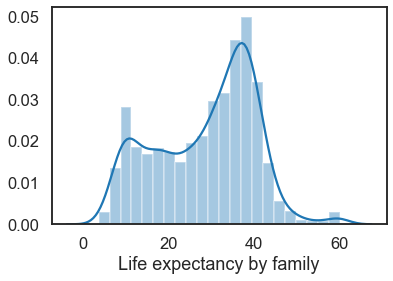

In [10]:
life_expectancy = lineage_df.groupby('family')['age'].agg(['mean', 'count']).reset_index()
ax = sns.distplot(life_expectancy['mean'])
ax.set(xlabel = 'Life expectancy by family')

[Text(0.5, 0, 'Total family size')]

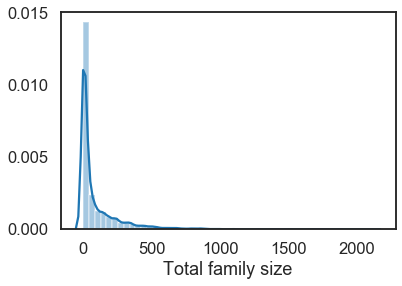

In [11]:
ax = sns.distplot(life_expectancy['count'])
ax.set(xlabel = 'Total family size')

In [12]:
scipy.stats.mode(life_expectancy['count'])

ModeResult(mode=array([2]), count=array([417]))

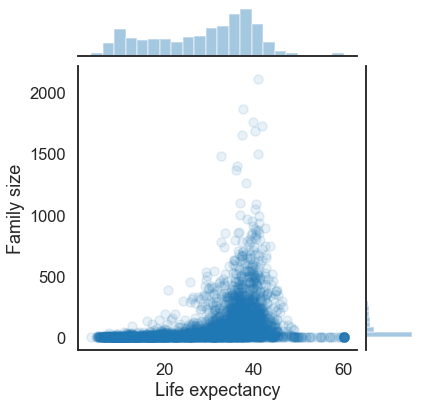

In [13]:
g = sns.jointplot(data=life_expectancy, x = 'mean', y = 'count', alpha = 0.1)
g.set_axis_labels(xlabel='Life expectancy', ylabel='Family size')

### Living population size over time

In [14]:
living_list = []
for fam in notebook.tqdm(boundless_families):
    fam_df = lineage_df[lineage_df['family'] == fam].copy().reset_index(drop=True)
    t = fam_df['tBirth'].values
    for ti in t:
        is_alive = (fam_df['tBirth'] <= ti) & (fam_df['tDeath'] > ti)
        pop = np.sum(is_alive)
        living_list.append((fam, ti, pop))

In [15]:
living_df = pd.DataFrame(living_list, columns = ['family', 't', 'population'])
living_df = living_df.sort_values(by=['family', 't'], ascending=True).reset_index(drop=True)
living_df['t0'] = living_df.groupby('family')['t'].transform('first')
living_df['t_elapsed'] = (living_df['t'] - living_df['t0'])/60/60
living_df.head()

,family,t,population,t0,t_elapsed
0,time-1573261529_eve-2252167_name-VIERNES,1573261529,1,1573261529,0.000000
1,time-1573261529_eve-2252167_name-VIERNES,1573261565,2,1573261529,0.010000
2,time-1573261796_eve-2252178_name-BELAND,1573261796,1,1573261796,0.000000
3,time-1573261796_eve-2252178_name-BELAND,1573261802,2,1573261796,0.001667
4,time-1573261796_eve-2252178_name-BELAND,1573261879,3,1573261796,0.023056


Plot a subset (to-do: sample by quintile)

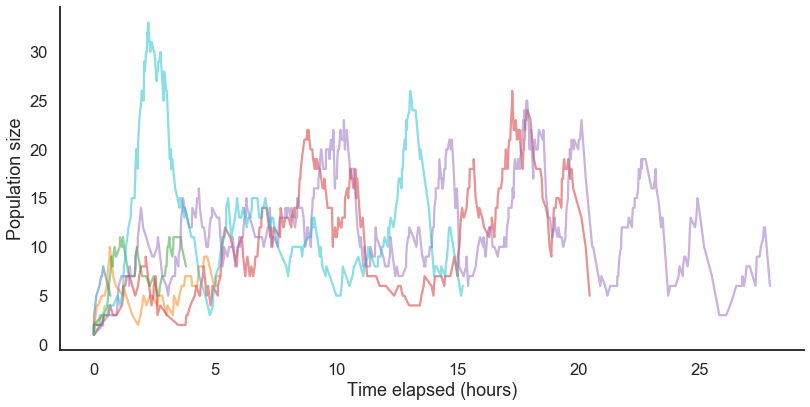

In [16]:
np.random.seed(526)
random_families = np.random.choice(boundless_families, size=10, replace=False)
random_subset = living_df[living_df['family'].isin(random_families)]
g = sns.relplot(data=random_subset, x='t_elapsed', y='population', hue='family', kind='line',
                 height=6, aspect=2, alpha = 0.5)
g.set(xlabel = 'Time elapsed (hours)', ylabel = 'Population size')
g._legend.remove()

Maximum population size

[Text(0.5, 0, 'Maximum living population size')]

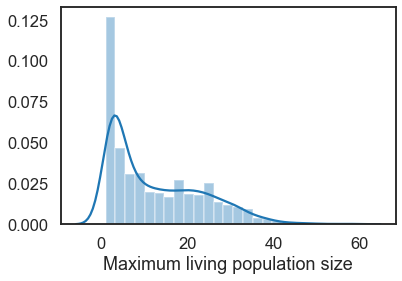

In [17]:
max_pop = living_df.groupby('family')['population'].agg('max').reset_index()
ax = sns.distplot(max_pop['population'])
ax.set(xlabel = 'Maximum living population size')

In [18]:
scipy.stats.mode(max_pop['population'])

ModeResult(mode=array([2]), count=array([487]))

### Chain length

Helper: Read JSON files

In [19]:
def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)

Find longest chain in family graphs

In [20]:
chain_list = []

for f in notebook.tqdm(boundless_families):
    fam_file = 'outputs/families/families_%s.json' % f
    fam_graph = open_graph(fam_file)
    fam_chain = nx.algorithms.dag_longest_path(fam_graph)
    chain_list.append((f, len(fam_chain)))

In [21]:
chain_df = pd.DataFrame(chain_list, columns=['family', 'chain'])
chain_df.head()

,family,chain
0,time-1573261529_eve-2252167_name-VIERNES,2
1,time-1573261796_eve-2252178_name-BELAND,2
2,time-1573261810_eve-2252180_name-BRAND,3
3,time-1573261816_eve-2252182_name-GERMAN,3
4,time-1573261826_eve-2252186_name-LOLI,3


In [22]:
scipy.stats.mode(chain_df['chain'])

ModeResult(mode=array([2]), count=array([932]))

[Text(0.5, 0, '# of generations')]

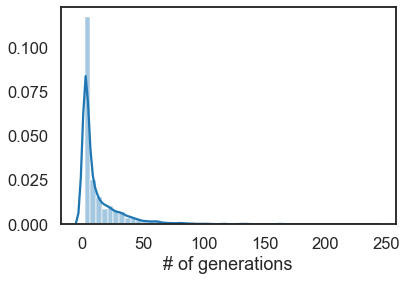

In [23]:
ax = sns.distplot(chain_df['chain'])
ax.set(xlabel = '# of generations')

## Modeling success

Criterion for "success": Reaching age 14 (viability fitness)

In [24]:
mortality_df = lineage_df.copy()
mortality_df['adult'] = (lineage_df['age'] >= 14)*1
mortality_df = mortality_df[['family', 'playerID', 'adult']]

mortality_summ = mortality_df.groupby('family')['adult'].agg(['sum', 'count']).reset_index()
mortality_summ['sum'] = mortality_summ['sum'].astype(np.int)
mortality_summ.head()

,family,sum,count
0,time-1573261529_eve-2252167_name-VIERNES,1,2
1,time-1573261796_eve-2252178_name-BELAND,2,8
2,time-1573261810_eve-2252180_name-BRAND,4,11
3,time-1573261816_eve-2252182_name-GERMAN,4,12
4,time-1573261826_eve-2252186_name-LOLI,4,16


Compute beta distribution for each family

Prior: Uniform
$$
\theta \sim \mathrm{Beta}(\alpha_0, \beta_0) \\
\alpha_0 = \beta_0 = 1
$$

Posterior-sufficient statistics:
$$
\theta | D \sim \mathrm{Beta}(\alpha_0 + k, \beta_0 + N - k) \\ 
a = \alpha_0 + k \\
b = \beta_0 + N - k
$$

In [25]:
def beta_mean(row): return scipy.stats.beta.mean(row['a'], row['b'])
def beta_var(row): return scipy.stats.beta.var(row['a'], row['b'])

mortality_summ['a'] = 3 + mortality_summ['sum']
mortality_summ['b'] = 3 + mortality_summ['count'] - mortality_summ['sum']
mortality_summ['beta_mean'] = mortality_summ.apply(beta_mean, axis=1)
mortality_summ['beta_var'] = mortality_summ.apply(beta_var, axis=1)
mortality_summ['snr'] = mortality_summ['beta_mean']/mortality_summ['beta_var']
mortality_summ['weighted_size'] = mortality_summ['beta_mean']*mortality_summ['count']
mortality_summ.to_csv('outputs/family_fitness.tsv', sep='\t', index=False)
mortality_summ.head()

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size
0,time-1573261529_eve-2252167_name-VIERNES,1,2,4,4,0.500000,0.027778,18.000000,1.000000
1,time-1573261796_eve-2252178_name-BELAND,2,8,5,9,0.357143,0.015306,23.333333,2.857143
2,time-1573261810_eve-2252180_name-BRAND,4,11,7,10,0.411765,0.013456,30.600000,4.529412
3,time-1573261816_eve-2252182_name-GERMAN,4,12,7,11,0.388889,0.012508,31.090909,4.666667
4,time-1573261826_eve-2252186_name-LOLI,4,16,7,15,0.318182,0.009432,33.733333,5.090909


### Compare candidate success measures

Beta mean:

[Text(0.5, 0, 'Mean viability ($\\mu$)')]

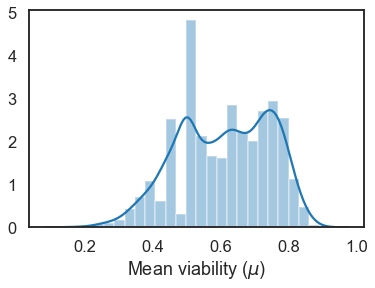

In [26]:
ax = sns.distplot(mortality_summ['beta_mean'])
ax.set(xlabel = 'Mean viability ($\mu$)')

Distribution of SNR:

[Text(0.5, 0, 'Signal-to-noise ratio ($\\mu/\\sigma$)')]

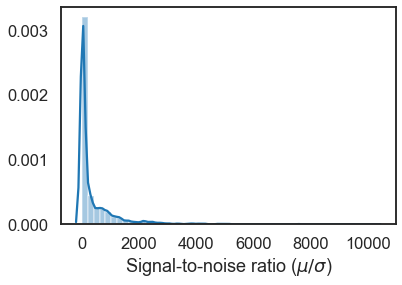

In [27]:
ax = sns.distplot(mortality_summ['snr'])
ax.set(xlabel='Signal-to-noise ratio ($\mu/\sigma$)')

Distribution of weighted size:

[Text(0.5, 0, 'Weighted family size ($\\mu N$)')]

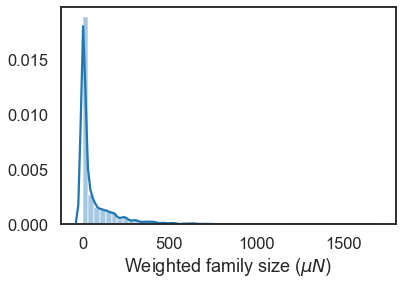

In [28]:
ax = sns.distplot(mortality_summ['weighted_size'])
ax.set(xlabel='Weighted family size ($\mu N$)')

Distribution of # adults:

[Text(0.5, 0, '# of adults')]

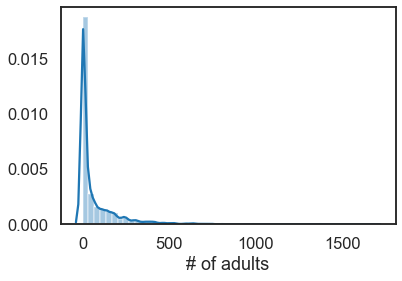

In [29]:
ax = sns.distplot(mortality_summ['sum'])
ax.set(xlabel='# of adults')

### Plot representative families

Split data into quartiles:

In [30]:
success = 'sum' # Success metric
mortality_summ['quantile'] = pd.qcut(mortality_summ[success], 4, labels=False)

What are the quantiles?

In [31]:
success_q = scipy.stats.mstats.mquantiles(mortality_summ[success], prob=[0.25, 0.5, 0.75, 1])
success_q

array([   2.,   11.,   84., 1678.])

Plot representative family trees from each quartile:

In [32]:
np.random.seed(526)
representative_families = np.array([np.random.choice(group['family'], 10) 
                                    for name,group in mortality_summ.groupby('quantile')])
rep_list = np.array(representative_families)
rep_list = rep_list.flatten()

rep_info = mortality_summ.copy()
rep_info = rep_info[rep_info['family'].isin(rep_list)]
rep_info = rep_info.reset_index(drop=True)
rep_info = rep_info.sort_values('quantile')
rep_info.to_csv('plots/fitness_quantiles/selected_families.tsv', sep='\t', index=None)
rep_info.head()

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,quantile
39,time-1592045655_eve-3072290_name-KORE,1,2,4,4,0.500000,0.027778,18.000000,1.000000,0
27,time-1586861179_eve-2886426_name-LEE,2,2,5,3,0.625000,0.026042,24.000000,1.250000,0
25,time-1585954343_eve-2852597_name-ZUZOLO,1,2,4,4,0.500000,0.027778,18.000000,1.000000,0
21,time-1584667836_eve-2804035_name-TURNIPSEED,2,3,5,4,0.555556,0.024691,22.500000,1.666667,0
17,time-1579811084_eve-2613051_name-HAPPY,2,8,5,9,0.357143,0.015306,23.333333,2.857143,0


In [33]:
for quant in notebook.tqdm(range(4)):
    for f in notebook.tqdm(representative_families[quant]):
        fam_file = 'outputs/families/families_%s.json' % f
        out_file = 'plots/fitness_quantiles/families_Q%i_%s.png' % (quant+1, f)

        # Chain length (for plot height)
        fam_graph = open_graph(fam_file)
        fam_chain = len(nx.algorithms.dag_longest_path(fam_graph))

        # Figure size (based on graphviz layout)
        nx.nx_agraph.write_dot(fam_graph,'fam.dot')
        pos=graphviz_layout(fam_graph, prog='dot')
        pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
        w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
        h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/150

        # Adjust for 2-member families
        w = max(w, 2)
        h = max(h, 2)

        # Node color (based on whether individuals reached maturity)
        fam_nodes = list(fam_graph.nodes)
        fam_nodes = [int(n) for n in fam_nodes]

        fam_attr = mortality_df[['playerID', 'adult']].copy()
        fam_attr = fam_attr[fam_attr['playerID'].isin(fam_nodes)]
        fam_attr = fam_attr.set_index('playerID')
        fam_attr = fam_attr.to_dict()

        fam_color = [fam_attr['adult'][n] == 1 for n in fam_nodes]
        fam_color = ['#4ab1ff' if c else '#cccccc' for c in fam_color]

        plt.figure(3,figsize=(w,h)) 
        nx.draw(fam_graph, pos, with_labels=False, arrows=True, node_color=fam_color)
        plt.savefig(out_file, transparent=True)
        plt.close()

KeyError: 2586932

## Plots for talk

Where are our representative families along this distribution?

In [ ]:
mortality_summ['log_n'] = np.log10(mortality_summ['sum'])
q_log = np.log10(success_q)
plt.figure(figsize=(12,4))
for q in q_log:
    plt.axvline(q, color='#aaaaaa', linestyle='--')
#plt.axvspan(0, q_log[0], alpha=0.5, color='red') 

ax = sns.distplot(mortality_summ['log_n'],bins=10)
ax.set_xlim(left=0)
ax.set_xticks(range(5))
labels = ['$10^{%i}$' % t for t in ax.get_xticks()]
ax.set(xlabel='# of adults', xticklabels=labels)
sns.despine()